# Statistics I: Chi-square independence test

[Independence](https://en.wikipedia.org/wiki/Independence_(probability_theory)) is a key concept in probability that describes a situation where knowing the value of one variable tells you nothing about the value of another. For instance, the month you were born probably doesn't tell you anything about which web browser you use, so we'd expect birth month and browser preference to be independent. On the other hand, your month of birth might be related to whether you excelled at sports in school, so month of birth and sports performance might not be independent.

The chi-squared test of independence tests whether two categorical variables are independent. The test of independence is commonly used to determine whether variables like education, political views and other preferences vary based on demographic factors like gender, race and religion. 

## I) Did Titanic passenger class affected survival? 

We use the same [Titanic dataset](https://www.kaggle.com/c/titanic/data) that we saw in the lecture. Our goal is to assess whether the passenger class affects the probability of survival (both are categorical) using the chi-square independence test. 
 
We start by installing the necessary packages if you do not have them already

In [ ]:
# We need to have pandas, matplotlib and scipy
import sys
!{sys.executable} -m pip install scipy numpy pandas matplotlib seaborn

In [1]:
# Loading the necessary
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats.distributions import chi2

import matplotlib.pyplot as plt
import seaborn as sns # Another package for making plots (we use it to make heatplots as it is easier)

Now let's load the dataset in Python using the `read_csv` method from the `pandas` package. 

In [2]:
# usecols allows us to select a subset of the columns to use 
data = pd.read_csv("titanic_data.csv", index_col='PassengerId', usecols=['PassengerId','Pclass','Survived'])
data.head(10)

,Survived,Pclass
PassengerId,,
1,0,3
2,1,1
3,1,3
4,1,1
5,0,3
6,0,3
7,0,1
8,0,3
9,1,3


for the column "Survived", 1 means the passenger survived and 0 means they did not survive 

In [3]:
# Check the dimensions of the dataset
data.shape

(891, 2)

### 1) Visual exploration

Let's compute a pivote table showing the number of people who survived or not given a certain passenger class

In [4]:
PClass_survd = pd.pivot_table(data, index=['Pclass'], columns=['Survived'], aggfunc='size')
PClass_survd

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


We can convert the values to relative frequencies per class, so we can better assess the effect of passenger class on survival

In [9]:
PClass_survd.sum(axis=1)

Pclass
1    216
2    184
3    491
dtype: int64

In [10]:
# Convert PClass_survd to relative frequencies per class
PClass_survd_prop = PClass_survd.div(PClass_survd.sum(axis=1), axis=0)
PClass_survd_prop

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


A final conversion step to simplify the visualisation of the effect of class passenger on survival:

In [13]:
# Convert to long format to be able to easily plot the effect of Pclass on survival
PClass_survd_prop_long = PClass_survd_prop.stack().reset_index()

# Rename the column "Survived" as "Survival":
PClass_survd_prop_long.rename(columns={'Survived':'Survival', 0: 'Prop'}, inplace=True)
# Rename the values in Pclass: 1 = 1st, 2 = 2nd, 3 = 3rd:
PClass_survd_prop_long['Pclass'].replace({1:'1st', 2:'2nd', 3:'3rd'}, inplace=True)
# Rename the values in Survived: 0 = Died, 1 = Survived:
PClass_survd_prop_long['Survival'].replace({0:'Died', 1:'Survived'}, inplace=True)

PClass_survd_prop_long

,Pclass,Survival,Prop
0,1st,Died,0.370370
1,1st,Survived,0.629630
2,2nd,Died,0.527174
3,2nd,Survived,0.472826
4,3rd,Died,0.757637
5,3rd,Survived,0.242363


Out of the 891 passengers, most in the third class died while most in first class survived. Now we can generate the plot using Seaborn package

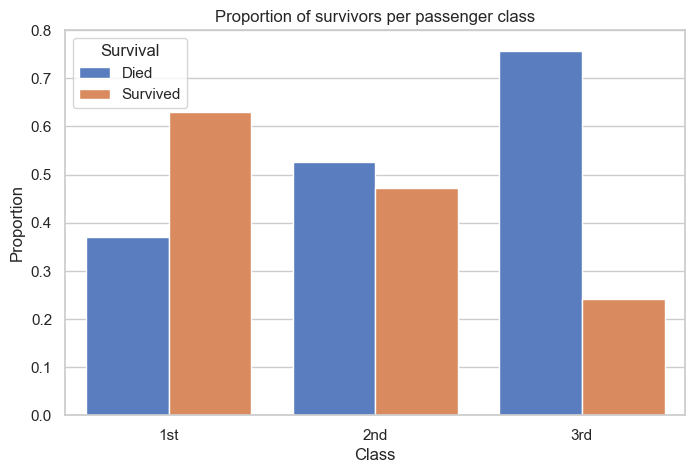

In [16]:
# Use Seaborne to plot the effect of Pclass on survival
sns.set(rc={'figure.figsize':(8, 5)})
sns.set_style("whitegrid")
sns.barplot(x='Pclass', y='Prop', hue='Survival', data=PClass_survd_prop_long, palette='muted') 
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Proportion of survivors per passenger class')
# y-axis limits between 0 and 0.8
plt.ylim(0,0.8)
plt.show()

Since the survival variable is binary, knowing the proportion of one outcome (e.g. Survived) is enough to know the proportion of the other outcome (e.g. Died). Therefore, we can plot the proportion of survivors only using the original data:

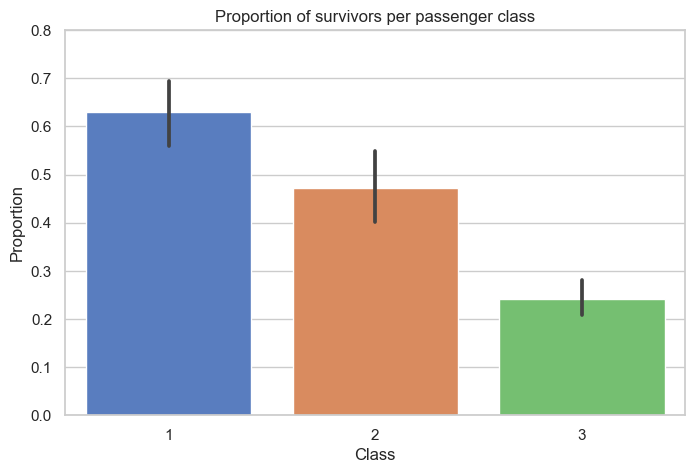

In [17]:
# Generate an alternative plot using the initial dataframe directly
sns.set(rc={'figure.figsize':(8, 5)})
sns.set_style("whitegrid")
sns.barplot(x='Pclass', y='Survived', data=data, palette='muted')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Proportion of survivors per passenger class')
# y-axis limits between 0 and 0.8
plt.ylim(0,0.8)
plt.show()

As you can see, the proportions match those of the "Survived" outcome in the previous graph. Error bars are also generated here, which gives as an indication about whether the differences between the different classes are significant or not (generally, we have significance if the error bars do not overlap).

## *STOP PLEASE. THE FOLLOWING IS FOR THE NEXT EXERCISE. THANKS.*

### 2) Implementation of the Chi-square test from scratch 

In order to see whether there is a relationship between passenger class and survival in the data, we will first run the Chi-square test by computing the test statistics, then producing the p-value. We can also perform the Chi-square test directly from the contigency table as we will demonstrate in Section 2 (faster method but I wanted to show you the mechanics of the test at least once).

In [29]:
# Get the count of each class
pct_class = PClass_survd.sum(axis=1)
pct_class

Pclass
1    216
2    184
3    491
dtype: int64

216 (24%) passengers belonged to Class 1, 184 (21%) to Class 2 and 491 (55%) to Class 3.

In [30]:
# Get the count of passengers who survived and those who did not 
pct_survived = PClass_survd.sum(axis=0)
pct_survived

Survived
0    549
1    342
dtype: int64

549 passengers survived (i.e. ~66%).

If we have a null hypothesis as 'The Survival does not depend on the Class the passengers were travelling', then we expect the distribution to be have similar proportions in all columns. Thats same proportion of people in all classes survived.

To get the expected count for a cell, multiply the row total for that cell by the column total for that cell and then divide by the total number of observations. So the expected contingency table will be the (dot) product of pct_class and pct_survived, divided by total_passengers.

In [32]:
# These are the expected number of people in all classes and survival history if the null hypothesis is true (.dot() does matrix multiplication)
exp = pct_class.to_frame().dot(pct_survived.to_frame().T)/891
exp

Survived,0,1
Pclass,,
1,133.090909,82.909091
2,113.373737,70.626263
3,302.535354,188.464646


Let's compare the observed and expected distributions using heatmap plots

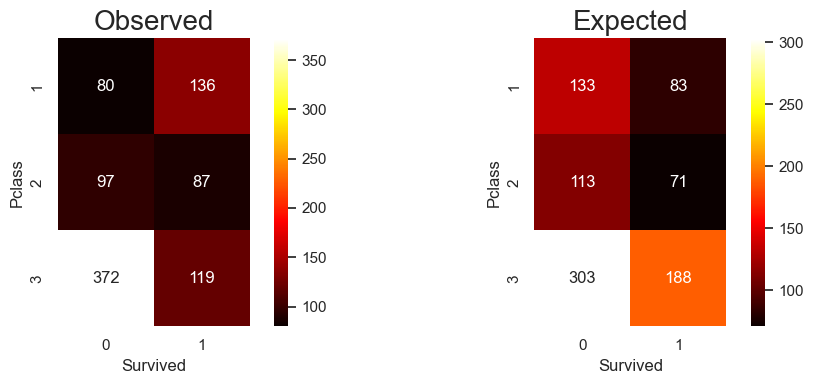

In [33]:
plt.figure(figsize=(10,4))

plt.subplot(121)
sns.heatmap(PClass_survd, annot=True, fmt='g', square=True, cmap='hot')
plt.title('Observed', fontsize=20)

plt.subplot(122)
sns.heatmap(round(exp), annot=True, fmt='g', square=True, cmap='hot')
plt.title('Expected', fontsize=20)
plt.tight_layout()


plt.show()

There seems to be a difference between the expected and the observed distributions, but could this difference occur by chance? Let's find out using the Chi-square test. For that we need to first compute the Chi-square test statistic.

In [ ]:
# TODO: Claculate the Chi-square statistic value (complete the code using what was covered in the lecture)
chi_table = ((PClass_survd - exp)**2)/exp
chi_table

Survived,0,1
Pclass,,
1,21.178341,33.996810
2,2.364739,3.796028
3,15.949664,25.603407


This table has the value of Chi-square for each class and the survival rate. The degrees of freedom for a test of independence equals the product of the number of categories in each variable minus 1. In this case we have a 3x2 table so df = 2x1 = 2.

In [ ]:
chi2_stat = chi_table.sum().sum()
p_value = 1 - stats.chi2.cdf(x = chi2_stat, df = 2)

print("Chi-square statistic is ", chi2_stat)
print("P-value is", p_value)

Chi-square statistic is  102.88898875696053
P-value is 0.0


The Chi-square table has the value of Chi-square for each class and the survival rate. The degrees of freedom for a test of independence equals the product of the number of categories in each variable minus 1. In this case we have a 3x2 table so df = 2x1 = 2.

Chi value is 101.8721 and p-value is < .001 

### 3) Chi-square test directly from the contingency table

Now let us see how the Chi-square test can be run directly from the contigency table.

In [36]:
chi2_stat, p_val, df, ex = stats.chi2_contingency(PClass_survd)

print("Chi square value is ", chi2_stat)
print("P value is", p_val)
print("Degrees of Freedom:", df)

Chi square value is  102.88898875696056
P value is 4.549251711298793e-23
Degrees of Freedom: 2


Here we see that the P-value is very low, suggesting strong evidence against the null hypothesis, and so we conclude that the survival of a passenger is not independent of their class.

## *STOP PLEASE. THE FOLLOWING IS FOR THE NEXT EXERCISE. THANKS.*

## II) Exercise: Is voting preference aftected by race?

Let's generate some fake voter polling data and perform a test of independence:

In [37]:
np.random.seed(10)

# Sample data randomly at fixed probabilities
voter_race = np.random.choice(a= ["asian","black","hispanic","other","white"],
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

# Sample data randomly at fixed probabilities
voter_party = np.random.choice(a= ["democrat","independent","republican"],
                              p = [0.4, 0.2, 0.4],
                              size=1000)

voters = pd.DataFrame({"race":voter_race, 
                       "party":voter_party})

voter_tab = pd.crosstab(voters.race, voters.party, margins = True)

voter_tab.columns = ["democrat","independent","republican","row_totals"]

voter_tab.index = ["asian","black","hispanic","other","white","col_totals"]

voter_tab

,democrat,independent,republican,row_totals
asian,21,7,32,60
black,65,25,64,154
hispanic,107,50,94,251
other,15,8,15,38
white,189,96,212,497
col_totals,397,186,417,1000


In [38]:
# Get table without totals for later use
observed = voter_tab.iloc[0:5,0:3]   
observed

,democrat,independent,republican
asian,21,7,32
black,65,25,64
hispanic,107,50,94
other,15,8,15
white,189,96,212


Note that we did not use the race data to inform our generation of the party data so the variables are independent.

Next you need to conduct a test of independence to check whether or not race and vote preference are independent. Report the chi-square statistic value, p-value and degrees of freedom. What do you conclude?

In [39]:
# TODO: replace the content of this cell with your Python solution
chi2_stat, p_val, df, ex = stats.chi2_contingency(observed)

print("Chi square value is ", chi2_stat)
print("P-value is", p_val)
print("Degrees of Freedom:", df)

Chi square value is  7.169321280162059
P value is 0.518479392948842
Degrees of Freedom: 8


The output shows the chi-square statistic, the p-value and the degrees of freedom followed by the expected counts. As expected, given the high p-value, the test result does not detect a significant relationship between the variables.

*Note: The degrees of freedom for a test of independence equals the product of the number of categories in each variable minus 1. In this case we have a 5x3 table so df = 4x2 = 8.*

## III) Guided tasks for the assessment

Complete the following tasks using the Open University dataset

1) Develop two interesting research hypotheses that involve nominal variables, and so are suitable for a Chi-square test. For each hypothesis, clearly formulate the null hypothesis (H0) and alternative hypothesis (H1). 

2) Conduct Chi-square tests to assesses the two hypotheses you have formulated. What do you conclude?

### Acknowledgement

The first section is based on a Jupyter notebook shared by Emrah Uz (https://www.kaggle.com/code/emrahuz/titanic-chi-square-test). The second section is based on a Jupyter notebook shared by Greg Hamel (https://www.kaggle.com/code/hamelg/python-for-data-25-chi-squared-tests/notebook).